In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# MODULES IMPORT

import pandas as pd
import numpy as np

from numpy.random import seed
import tensorflow as tf
import random as rn
import os
from nltk import tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
# GOOGLE COLAB SETUP

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Importing Data

train = pd.read_csv('/content/drive/MyDrive/SJ-DECEN_code/data/train_cleaned_no_punkt.csv')
test_labelled = pd.read_csv('/content/drive/MyDrive/SJ-DECEN_code/data/test_labelled_cleaned_no_punkt.csv')
test_unlabelled = pd.read_csv('/content/drive/MyDrive/SJ-DECEN_code/data/test_unlabelled_cleaned_no_punkt.csv')

In [8]:
print("No. of records in the Training set:", train.shape)
print("No. of records in the Testing set (labelled):",test_labelled.shape)
print("No. of records in the Testing set (Unlabelled):",test_unlabelled.shape)

No. of records in the Training set: (159571, 8)
No. of records in the Testing set (labelled): (63978, 8)
No. of records in the Testing set (Unlabelled): (89186, 8)


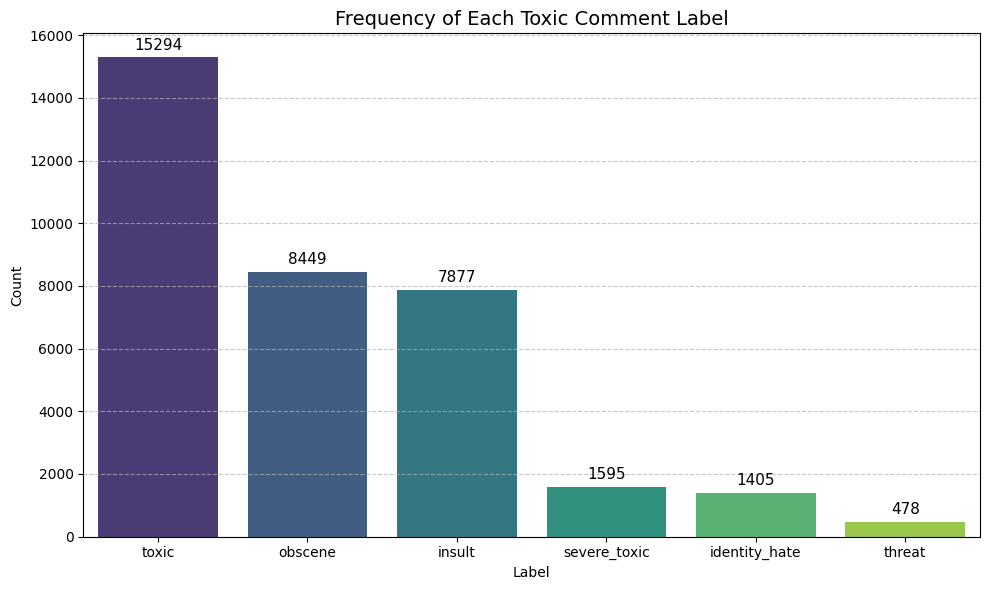

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# List of label columns
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Count the number of occurrences for each label
label_counts = train[label_cols].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')

# Add count labels on top of each bar
for index, value in enumerate(label_counts.values):
    plt.text(index, value + max(label_counts.values)*0.01, str(int(value)), ha='center', va='bottom', fontsize=11)

# Title and labels
plt.title('Frequency of Each Toxic Comment Label', fontsize=14)
plt.xlabel('Label')
plt.ylabel('Count')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [11]:
train['mal']    = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) >= 1
train.drop(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis=1, inplace=True)
train.comment_text.fillna("empty", inplace=True)

test_labelled['mal'] = test_labelled[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) >= 1
test_labelled.drop(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis=1, inplace=True)
test_labelled.comment_text.fillna("empty", inplace=True)

test_unlabelled.comment_text.fillna("empty", inplace=True)

In [ ]:
# CHANGE TRAIN AND TEST, MIX TO GET SIMILAR DISTRIBUTION

from sklearn.model_selection import train_test_split
rs=42
X_train1, X_test1, y_train1, y_test1  = train_test_split(train.drop('mal', axis=1), train.mal, stratify=train.mal, test_size=0.29, random_state=rs )
X_train2, X_test2, y_train2, y_test2  = train_test_split(test_labelled.drop('mal', axis=1), test_labelled.mal, stratify=test_labelled.mal, test_size=0.29, random_state=rs)

X = np.concatenate((X_train1.comment_text, X_train2.comment_text))
y = np.concatenate((y_train1, y_train2))

X_test = np.concatenate((X_test1.comment_text, X_test2.comment_text))
y_test = np.concatenate((y_test1, y_test2))

In [ ]:
max_features = 40000
maxlen       = 400
dropout_rate = 0.25
rs           = 42
epochs       = 4
batch_size   = 256
embed_dim    = 50
rec_units    = 150


max_sen_len    = 100
max_sent_amount = 4

seed(rs)
# set_random_seed(rs)
rn.seed(rs)

os.environ['PYTHONHASHSEED']=str(rs)

# GRU

In [ ]:
import keras
from keras.layers import Embedding, SpatialDropout1D
from keras.layers import Dense, Input, GRU, LSTM
from keras.layers import Bidirectional, Dropout, GlobalMaxPool1D
from tensorflow.keras.layers import GRU  # Handles both CPU and GPU
from keras.layers import Conv1D, GlobalMaxPooling1D, TimeDistributed
from keras.layers import Dense, Embedding, Input

from keras.models import Model, Sequential
from keras.optimizers import RMSprop
import keras.backend as K
# from keras.engine.topology import Layer, InputSpec
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputSpec
from keras.models import load_model

# from keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras import initializers as initializers, regularizers, constraints

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
from nltk import tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
import os

cv_models_path = '/content/drive/MyDrive/SJ-DECEN_code/base_models/saved_models/'
os.makedirs(cv_models_path, exist_ok=True)

In [ ]:
def gru_keras(max_features, maxlen, bidirectional, dropout_rate, embed_dim, rec_units,mtype='GRU', reduction = None):

    if K.backend == 'tensorflow':
        K.clear_session()

    input_layer     = Input(shape=(maxlen,))
    embedding_layer = Embedding(max_features, output_dim=embed_dim, trainable=True)(input_layer)
    x               = SpatialDropout1D(dropout_rate)(embedding_layer)

    if reduction:
        if mtype   == 'GRU':
            if bidirectional:
                x           = Bidirectional(GRU(units=rec_units, return_sequences=True))(x)
            else:
                x           = GRU(units=rec_units, return_sequences=True)(x)

        if reduction == 'average':
          x = GlobalAveragePooling1D()(x)
        elif reduction == 'maximum':
          x = GlobalMaxPool1D()(x)
        # elif reduction == 'attention':
        #   x = AttentionWithContext()(x)
    else:
        if mtype   == 'GRU':
            if bidirectional:
                x           = Bidirectional(GRU(units=rec_units, return_sequences=False))(x)
            else:
                x           = GRU(units=rec_units, return_sequences=False)(x)

    output_layer = Dense(1, activation="sigmoid")(x)
    model        = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy',
                  # Choose either clipnorm or clipvalue, but not both
                  optimizer=RMSprop(clipvalue=1),  # Or optimizer=RMSprop(clipnorm=1)
                  metrics=['acc'])
    return model

In [ ]:
def dl_model(model_type='BGRU', max_features=40000, embed_dim=50, rec_units=150, dropout_rate=0.25, maxlen=400, max_sent_len=100, max_sent_amount=4):

    if model_type == 'GRU':
        return gru_keras(max_features=max_features, maxlen=maxlen, bidirectional=False, mtype='GRU',
                         dropout_rate=dropout_rate, embed_dim=embed_dim, rec_units=rec_units)
    if model_type == 'BGRU':
        return gru_keras(max_features=max_features, maxlen=maxlen, bidirectional=True, mtype='GRU',
                         dropout_rate=dropout_rate, embed_dim=embed_dim, rec_units=rec_units)


In [ ]:
def train_model(X, y, mtype, cv, epochs,
                train, X_test=None, y_test=None, nfolds=None,
                rs=42, max_features=40000, maxlen=400, dropout_rate=0.25,
                rec_units=150, embed_dim=50, batch_size=256, max_sen_len=100,
                max_sent_amount=4, threshold=0.3, cv_models_path='saved_models'):
    if cv:
        kf = StratifiedKFold(n_splits=nfolds, random_state=rs, shuffle=True)
        auc = []
        roc = []
        fscore_ = []

        for c, (train_index, val_index) in enumerate(kf.split(X, y)):

            print(f' fold {c}')

            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            tokenizer = Tokenizer(num_words=max_features)
            tokenizer.fit_on_texts(X_train)

            list_tokenized_train = tokenizer.texts_to_sequences(X_train)
            list_tokenized_val   = tokenizer.texts_to_sequences(X_val)

            X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
            X_val   = pad_sequences(list_tokenized_val, maxlen=maxlen)

            model = dl_model(model_type=mtype, max_features=max_features,
            maxlen=maxlen, dropout_rate=dropout_rate, embed_dim=embed_dim,
            rec_units=rec_units, max_sent_len=max_sen_len, max_sent_amount=max_sent_amount)

            print('Fitting')
            if train:
                model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=1)
                model.save_weights(f'{cv_models_path}/{mtype}_fold_{c}.weights.h5')

            else:

                model.load_weights(f'{cv_models_path}/{mtype}_fold_{c}.weights.h5')


            probs = model.predict(X_val, batch_size=batch_size, verbose=1)

            #for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
            threshold = threshold
            probs_class = probs.copy()
            probs_class[probs_class >= threshold] = 1
            probs_class[probs_class < threshold] = 0
            precision = precision_score(y_val, probs_class)
            recall    = recall_score(y_val, probs_class)
            fscore    = f1_score(y_val, probs_class)
            print(f' {threshold} fold {c} precision {round(precision, 3)} recall {round(recall, 3)} fscore {round(fscore,3)}')

            auc_f = average_precision_score(y_val, probs)

            auc.append(auc_f)
            roc_f = roc_auc_score(y_val, probs)
            roc.append(roc_f)
            fscore_.append(fscore)
            print(f'fold {c} average precision {round(auc_f, 3)}')
            print(f'fold {c} roc auc {round(roc_f, 3)}')

            del model
            K.clear_session()

        print(f'PR-C {round(np.array(auc).mean(), 3)}')
        print(f'ROC AUC {round(np.array(roc).mean(), 3)}')
        print(f'FScore {round(np.array(fscore_).mean(), 3)}')

        print(f'PR-C std {round(np.array(auc).std(), 3)}')
        print(f'ROC AUC std {round(np.array(roc).std(), 3)}')
        print(f'FScore std {round(np.array(fscore_).std(), 3)}')
    else:
            X_train   = X
            y_train   = y
            tokenizer = Tokenizer(num_words=max_features, oov_token='unknown')
            tokenizer.fit_on_texts(X_train)

            list_tokenized_train = tokenizer.texts_to_sequences(X_train)
            list_tokenized_test  = tokenizer.texts_to_sequences(X_test)
            X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
            X_test  = pad_sequences(list_tokenized_test, maxlen=maxlen)

            y_train = np.array(y_train)
            y_test  = np.array(y_test)

            model = dl_model(model_type=mtype, max_features=max_features,
            maxlen=maxlen, dropout_rate=dropout_rate, embed_dim=embed_dim,
            rec_units=rec_units, max_sent_len=max_sen_len, max_sent_amount=max_sent_amount)

            print('Fitting')

            if train:
                model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=1)
                model.save_weights(f'{cv_models_path}/{mtype}_fold_{c}.weights.h5')

            else:
                model.load_weights(f'{cv_models_path}/{mtype}_fold_{c}.weights.h5')
            probs = model.predict(X_test, batch_size=batch_size, verbose=1)
            auc_f = average_precision_score(y_test, probs)
            roc_f = roc_auc_score(y_test, probs)


            threshold = threshold
            probs_class = probs.copy()
            probs_class[probs_class >= threshold] = 1
            probs_class[probs_class < threshold] = 0
            precision = precision_score(y_test, probs_class)
            recall    = recall_score(y_test, probs_class)
            fscore    = f1_score(y_test, probs_class)

            print('_________________________________')
            print(f'PR-C is {round(auc_f,3)}')
            print('_________________________________\n')

            print('_________________________________')
            print(f'ROC AUC is {round(roc_f,3)}')
            print('_________________________________')

            print('_________________________________')
            print(f'FScore is {round(fscore,3)}')
            print('_________________________________\n')

In [ ]:
train_model(
    X=X,
    y=y,
    mtype='GRU',
    cv=True,
    nfolds=2,
    epochs=4,
    cv_models_path=cv_models_path,
    train=True,  # Set to True if you want to train and save the model
    rs=42
)

 fold 0
Fitting
Epoch 1/4
310/310 ━━━━━━━━━━━━━━━━━━━━ 947s 3s/step - acc: 0.9024 - loss: 0.3061
Epoch 2/4
310/310 ━━━━━━━━━━━━━━━━━━━━ 935s 3s/step - acc: 0.9442 - loss: 0.1668
Epoch 3/4
310/310 ━━━━━━━━━━━━━━━━━━━━ 993s 3s/step - acc: 0.9511 - loss: 0.1375
Epoch 4/4
310/310 ━━━━━━━━━━━━━━━━━━━━ 1002s 3s/step - acc: 0.9569 - loss: 0.1212
310/310 ━━━━━━━━━━━━━━━━━━━━ 249s 803ms/step
 0.3 fold 0 precision 0.63 recall 0.837 fscore 0.719
fold 0 average precision 0.829
fold 0 roc auc 0.961
 fold 1
Fitting
Epoch 1/4
310/310 ━━━━━━━━━━━━━━━━━━━━ 943s 3s/step - acc: 0.9017 - loss: 0.3092
Epoch 2/4
310/310 ━━━━━━━━━━━━━━━━━━━━ 969s 3s/step - acc: 0.9434 - loss: 0.1698
Epoch 3/4
310/310 ━━━━━━━━━━━━━━━━━━━━ 965s 3s/step - acc: 0.9530 - loss: 0.1364
Epoch 4/4
310/310 ━━━━━━━━━━━━━━━━━━━━ 920s 3s/step - acc: 0.9559 - loss: 0.1205
310/310 ━━━━━━━━━━━━━━━━━━━━ 257s 830ms/step
 0.3 fold 1 precision 0.738 recall 0.767 fscore 0.752
fold 1 average precision 0.824
fold 1 roc auc 0.961
PR-C 0.827
ROC AUC

In [ ]:
mtype = 'GRU'
cv_models_path = 'saved_models'
nfolds = 2
max_features = 40000
maxlen = 400
batch_size = 256
threshold = 0.3
random_state = 42

kf = StratifiedKFold(n_splits=nfolds, random_state=random_state, shuffle=True)

for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
    print(f"\n--- Fold {fold+1} ---")

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Re-create tokenizer and preprocess validation data
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(X_train)
    X_val_seq = tokenizer.texts_to_sequences(X_val)
    X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen)

    # Rebuild the model
    model = dl_model(
        model_type=mtype,
        max_features=max_features,
        maxlen=maxlen,
        dropout_rate=0.25,
        embed_dim=50,
        rec_units=150,
        max_sent_len=100,
        max_sent_amount=4
    )

    # Load the corresponding weights
    weight_file = os.path.join(cv_models_path, f"{mtype}_fold_{fold}.weights.h5")
    model.load_weights(weight_file)

    # Predict probabilities and apply threshold
    probs = model.predict(X_val_pad, batch_size=batch_size, verbose=1)
    preds = (probs >= threshold).astype(int).flatten()

    # Print classification report
    print(classification_report(y_val, preds, digits=2))


--- Fold 1 ---


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


310/310 ━━━━━━━━━━━━━━━━━━━━ 292s 943ms/step
              precision    recall  f1-score   support

       False       0.98      0.94      0.96     71384
        True       0.63      0.84      0.72      7976

    accuracy                           0.93     79360
   macro avg       0.81      0.89      0.84     79360
weighted avg       0.95      0.93      0.94     79360


--- Fold 2 ---


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


310/310 ━━━━━━━━━━━━━━━━━━━━ 264s 851ms/step
              precision    recall  f1-score   support

       False       0.97      0.97      0.97     71383
        True       0.74      0.77      0.75      7976

    accuracy                           0.95     79359
   macro avg       0.86      0.87      0.86     79359
weighted avg       0.95      0.95      0.95     79359



## BGRU

In [ ]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    average_precision_score, roc_auc_score,
    classification_report
)

def train_model(X, y, mtype, cv, epochs,
                train, X_test=None, y_test=None, nfolds=None,
                rs=42, max_features=40000, maxlen=400, dropout_rate=0.25,
                rec_units=150, embed_dim=50, batch_size=256, max_sen_len=100,
                max_sent_amount=4, threshold=0.3, cv_models_path='saved_models'):

    if cv:
        kf = StratifiedKFold(n_splits=nfolds, random_state=rs, shuffle=True)
        auc = []
        roc = []
        fscore_ = []

        for c, (train_index, val_index) in enumerate(kf.split(X, y)):
            print(f'\n======== Fold {c} ========')

            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            tokenizer = Tokenizer(num_words=max_features)
            tokenizer.fit_on_texts(X_train)

            # === Preprocessing ===

            X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=maxlen)
            X_val = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=maxlen)

            # === Build model ===
            model = dl_model(
                model_type=mtype, max_features=max_features, maxlen=maxlen,
                dropout_rate=dropout_rate, embed_dim=embed_dim,
                rec_units=rec_units, max_sent_len=max_sen_len, max_sent_amount=max_sent_amount
            )

            print('Fitting')
            if train:
                model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=1)
                model.save_weights(f'{cv_models_path}/{mtype}_fold_{c}.weights.h5')
            else:
                model.load_weights(f'{cv_models_path}/{mtype}_fold_{c}.weights.h5')

            probs = model.predict(X_val, batch_size=batch_size, verbose=1)
            preds = (probs >= threshold).astype(int)

            # === Metrics ===
            precision = precision_score(y_val, preds)
            recall = recall_score(y_val, preds)
            fscore = f1_score(y_val, preds)
            auc_f = average_precision_score(y_val, probs)
            roc_f = roc_auc_score(y_val, probs)

            auc.append(auc_f)
            roc.append(roc_f)
            fscore_.append(fscore)

            print(f'Precision: {precision:.3f} | Recall: {recall:.3f} | F1-score: {fscore:.3f}')
            print(f'Avg Precision (PR-C): {auc_f:.3f} | ROC AUC: {roc_f:.3f}')

            # >>> Include classification report
            print('\nClassification Report:')
            print(classification_report(y_val, preds, digits=2))

            del model
            K.clear_session()

        print('\n====== Cross-Validation Summary ======')
        print(f'Avg PR-C: {np.mean(auc):.3f} ± {np.std(auc):.3f}')
        print(f'Avg ROC AUC: {np.mean(roc):.3f} ± {np.std(roc):.3f}')
        print(f'Avg F1 Score: {np.mean(fscore_):.3f} ± {np.std(fscore_):.3f}')

    else:
        # ==== Non-CV Mode ====
        tokenizer = Tokenizer(num_words=max_features, oov_token='unknown')
        tokenizer.fit_on_texts(X)


        X_train = pad_sequences(tokenizer.texts_to_sequences(X), maxlen=maxlen)
        X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=maxlen)

        y_train = np.array(y)
        y_test = np.array(y_test)

        model = dl_model(
            model_type=mtype, max_features=max_features, maxlen=maxlen,
            dropout_rate=dropout_rate, embed_dim=embed_dim,
            rec_units=rec_units, max_sent_len=max_sen_len, max_sent_amount=max_sent_amount
        )

        print('Fitting')
        if train:
            model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=1)
            model.save_weights(f'{cv_models_path}/{mtype}_full_model.weights.h5')
        else:
            model.load_weights(f'{cv_models_path}/{mtype}_full_model.weights.h5')

        probs = model.predict(X_test, batch_size=batch_size, verbose=1)
        preds = (probs >= threshold).astype(int)

        precision = precision_score(y_test, preds)
        recall = recall_score(y_test, preds)
        fscore = f1_score(y_test, preds)
        auc_f = average_precision_score(y_test, probs)
        roc_f = roc_auc_score(y_test, probs)

        print('_________________________________')
        print(f'PR-C is {round(auc_f,3)}')
        print(f'ROC AUC is {round(roc_f,3)}')
        print(f'F1-score is {round(fscore,3)}')
        print('_________________________________')

        # >>> Include classification report
        print('\nClassification Report:')
        print(classification_report(y_test, preds, digits=2))


In [ ]:
train_model(
    X=X,
    y=y,
    mtype='BGRU',
    cv=True,
    nfolds=2,
    epochs=4,
    train=True,
    rs=42,
    cv_models_path='saved_models'
)



======== Fold 0 ========
Fitting
Epoch 1/4
310/310 ━━━━━━━━━━━━━━━━━━━━ 1931s 6s/step - acc: 0.9030 - loss: 0.3168
Epoch 2/4
310/310 ━━━━━━━━━━━━━━━━━━━━ 1949s 6s/step - acc: 0.9455 - loss: 0.1593
Epoch 3/4
310/310 ━━━━━━━━━━━━━━━━━━━━ 1997s 6s/step - acc: 0.9531 - loss: 0.1302
Epoch 4/4
310/310 ━━━━━━━━━━━━━━━━━━━━ 2005s 6s/step - acc: 0.9591 - loss: 0.1133
310/310 ━━━━━━━━━━━━━━━━━━━━ 456s 1s/step
Precision: 0.786 | Recall: 0.714 | F1-score: 0.748
Avg Precision (PR-C): 0.824 | ROC AUC: 0.956

Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.98      0.97     71384
        True       0.79      0.71      0.75      7976

    accuracy                           0.95     79360
   macro avg       0.88      0.85      0.86     79360
weighted avg       0.95      0.95      0.95     79360


======== Fold 1 ========
Fitting
Epoch 1/4
310/310 ━━━━━━━━━━━━━━━━━━━━ 1871s 6s/step - acc: 0.8992 - loss: 0.3145
Epoch 2/4
310/310 ━━━━━━━━━━━━━━━